In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.optimize as opt  


source 

https://docs.mosek.com/portfolio-cookbook/markowitz.html#equation-doc-eq-markowitz-utility-unconstr

# On simule des returns

In [ ]:
def generate_multivariate_normal_returns(
    n_obs: int,
    annual_means: np.ndarray,
    annual_sigmas: np.ndarray,
    correlation_matrix: np.ndarray
) -> np.ndarray:
    """
    truc rapide pour simuler des returns 
    """
    annual_means = np.array(annual_means, dtype=float)
    annual_sigmas = np.array(annual_sigmas, dtype=float)
    correlation_matrix = np.array(correlation_matrix, dtype=float)

    n_assets = len(annual_means)
    if correlation_matrix.shape != (n_assets, n_assets):
        raise ValueError(f"La matrice de corrélation doit être de taille ({n_assets}, {n_assets}).")

    # Conversion annualisé => journalier
    daily_means = annual_means / 252.0
    daily_sigmas = annual_sigmas / np.sqrt(252.0)

    # Construction de la matrice de covariance
    cov_matrix = np.zeros((n_assets, n_assets))
    for i in range(n_assets):
        for j in range(n_assets):
            cov_matrix[i, j] = correlation_matrix[i, j] * daily_sigmas[i] * daily_sigmas[j]

    # Génération des données
    returns = np.random.multivariate_normal(mean=daily_means, cov=cov_matrix, size=n_obs)
    return returns

# On a une classe qui gère l'optimisation sur les fenêtres 

on contrôle le batch size et l'ecart entre les entrainements (overlap)

In [ ]:
class MaxSharpe():
    def __init__(self, risk_aversion:float = 1, batch_size:int = 100, overlap:int = 1) -> None:
        self.risk_aversion = risk_aversion
        self.overlap = overlap
        self.batch_size = batch_size

    def _compute_weights(self, batch:np.ndarray) -> np.ndarray:
        """ 
        Computes the markowitz solution over the batch 
        data is assumed to be on a daily basis 
        """
        mean_vector = np.mean(batch, axis=0) * 252 
        cov_matrix = np.cov(batch, rowvar=False) * np.sqrt(252) 
        w = self._markowitz_optimizer(cov_matrix, mean_vector)
        return w 
    
    def _markowitz_optimizer(self, cov_matrix:np.ndarray, mean_vector:np.ndarray) -> float:
        """
        solves the Markowitz problem with scipy 
        weights constraints : equal to one, no short selling
        """
        def target_func(weights:np.ndarray) -> float:
            f = mean_vector @ weights - (self.risk_aversion / 2) * weights.T @ cov_matrix @ weights
            return -f # on veut un problème de minimisation

        n_assets = len(mean_vector)  
        
        constraints = [{'type': 'eq', 'fun': lambda x : np.sum(x) - 1}] 
        bounds = [(0, None)] * n_assets

        x0 = np.ones(n_assets) / n_assets
        res = opt.minimize(
            target_func, 
            x0, 
            constraints=constraints,
            bounds=bounds
            )

        return res.x  

    def train(self, returns: np.ndarray) -> None:
        """
        trains the model 
        """
        n_obs, n_assets = returns.shape
        self.weights = np.zeros((n_obs, n_assets))

        # Initialisation des poids (avant la première fenêtre)
        for t in range(self.batch_size):
            self.weights[t, :] = np.ones(n_assets) / n_assets

        # On avance par pas de self.overlap jours :
        for t in range(self.batch_size, n_obs, self.overlap):
            window_returns = returns[t - self.batch_size : t, :]
            w = self._compute_weights(window_returns)

            for day in range(t, min(t + self.overlap, n_obs)):
                self.weights[day, :] = w
    
    def simulate_rets_portfolio(self, returns: np.ndarray) -> np.ndarray:
        """
        Calcule le rendement du portefeuille jour par jour en utilisant self.weights,
        selon la convention B (on applique les poids du jour t-1 au jour t).
        """
        n_obs, _ = returns.shape
        port_rets = np.zeros(n_obs)
        port_rets[0] = returns[0] @ self.weights[0, :]
        
        for t in range(1, n_obs):
            port_rets[t] = returns[t] @ self.weights[t - 1, :]

        return port_rets

In [325]:
def plot_portfolio_results(returns, batch_size, overlap, risk_aversion, figsize=(15, 3)) -> None:
    """
    Affiche deux graphiques :
    0) Les poids
    1) La série de rendements du portefeuille
    2) La performance cumulée
    """

    model = MaxSharpe(risk_aversion, batch_size, overlap)
    model.train(returns)
    portfolio_returns = model.simulate_rets_portfolio(returns)

    # Graphique 0 : poids

    plt.figure(figsize=figsize)
    plt.subplot(131)
    plt.plot(model.weights)
    plt.title("Rendements journaliers du portefeuille")
    plt.xlabel("Jour")
    plt.ylabel("Rendement")

    # Graphique 1 : rendements journaliers
    
    plt.subplot(132)
    plt.plot(portfolio_returns)
    plt.title("Rendements journaliers du portefeuille")
    plt.xlabel("Jour")
    plt.ylabel("Rendement")

    # Graphique 2 : performance cumulée
    plt.subplot(133)
    plt.plot(np.cumprod(portfolio_returns + 1))
    plt.title("Performance cumulée du portefeuille")
    plt.xlabel("Jour")
    plt.ylabel("Cumul (base 1.0)")

    plt.show()

    sharpe = (np.mean(portfolio_returns) / np.std(portfolio_returns)) * np.sqrt(252)
    print("sharpe ratio", sharpe)
    return sharpe


# Exemple numérique 

In [317]:
np.random.seed(42)

# Simulation et calcul des poids 

In [318]:
batch_size = 200
overlap = 1 
n_obs = 2_000
annual_means = [0.15, 0.30, 0.10]
annual_sigmas = [0.20, 0.70, 0.25]
corr_matrix = np.array([
    [1.0,  -0.7,  0.2 ],
    [-0.7,  1.0, -0.1 ],
    [0.2,  -0.1,  1.0 ]
])

returns = generate_multivariate_normal_returns(
    n_obs, annual_means, annual_sigmas, corr_matrix
)

model = MaxSharpe(overlap=overlap, batch_size=batch_size)
model.train(returns)
portfolio_sim = model.simulate_rets_portfolio(returns)

prix des assets simulés 

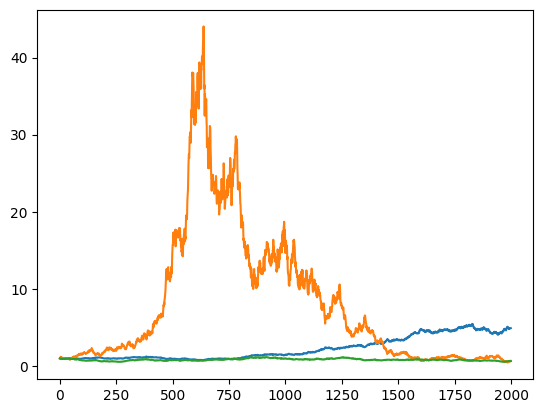

In [319]:
plt.plot(np.cumprod((1 + returns), axis=0))
plt.show()

# rendements du portefeulle optimal selon les différents paramètres 

0.5 10 1


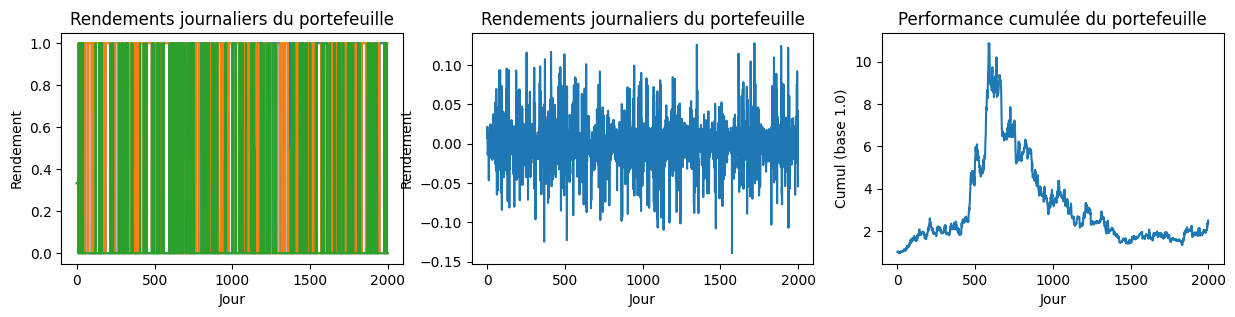

sharpe ratio 0.4680959285564065
0.5 10 10


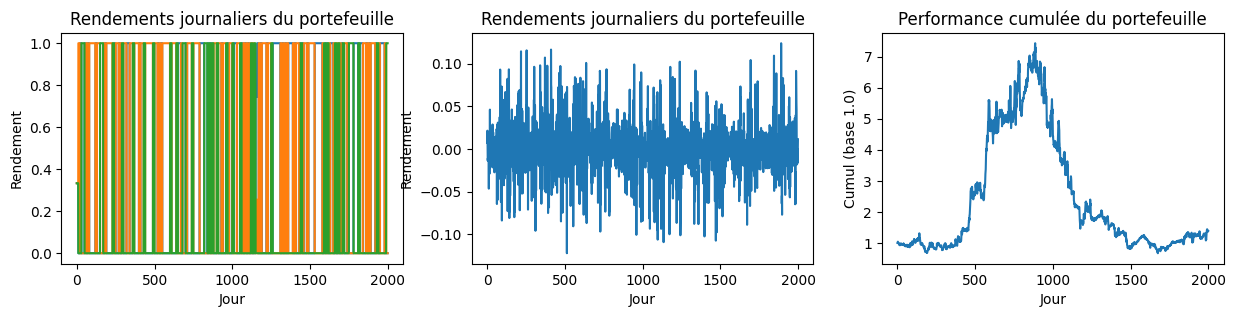

sharpe ratio 0.33201473951394295
0.5 100 1


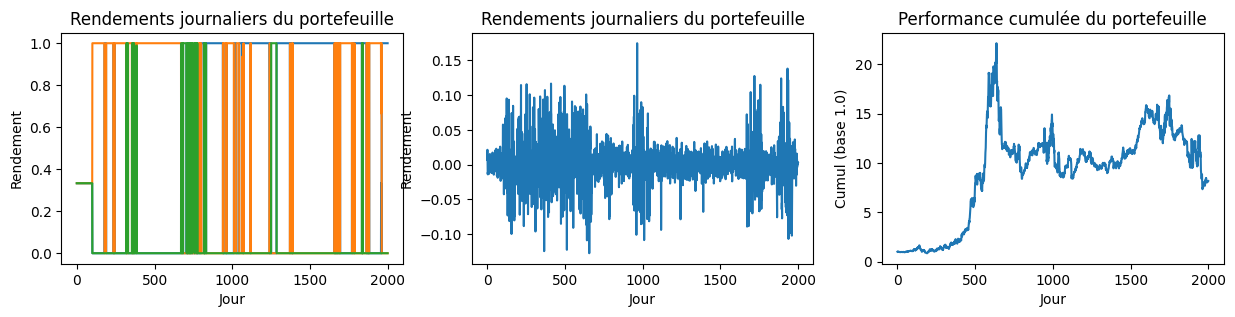

sharpe ratio 0.7839195417597494
0.5 100 10


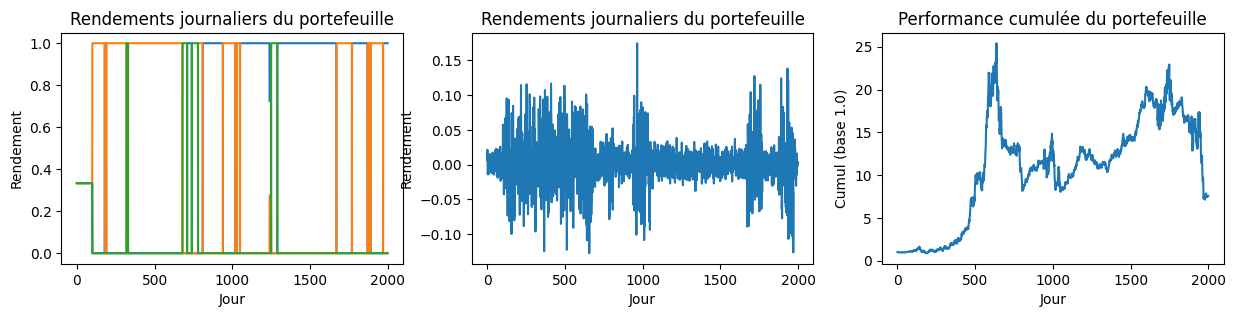

sharpe ratio 0.7622037516630659
1.0 10 1


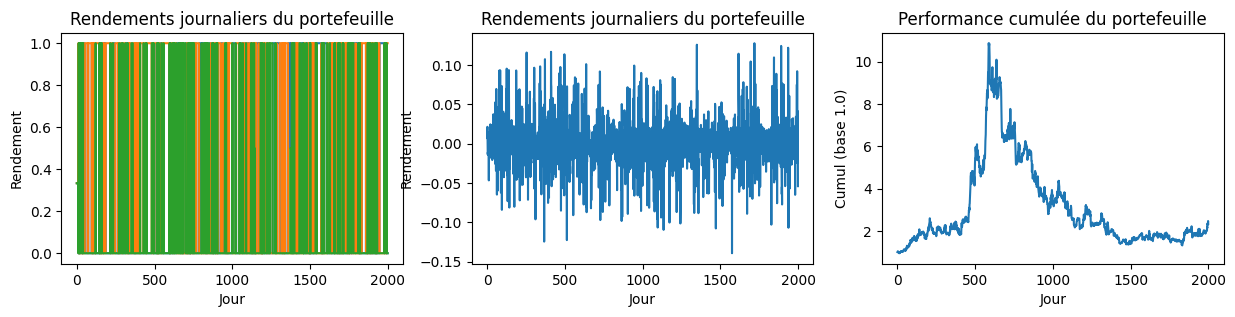

sharpe ratio 0.4647083092779065
1.0 10 10


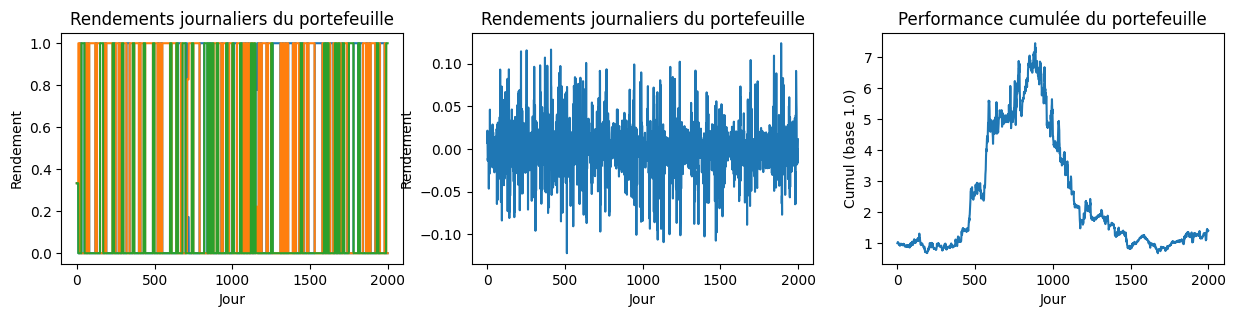

sharpe ratio 0.33502106252808855
1.0 100 1


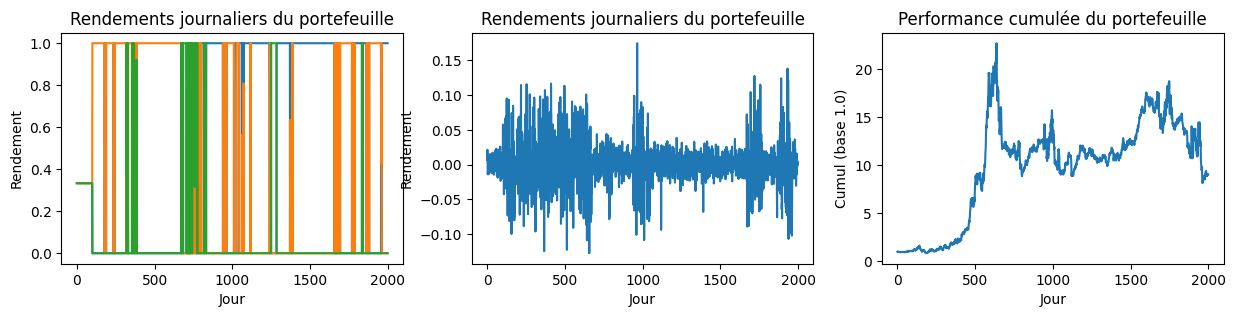

sharpe ratio 0.811756371068143
1.0 100 10


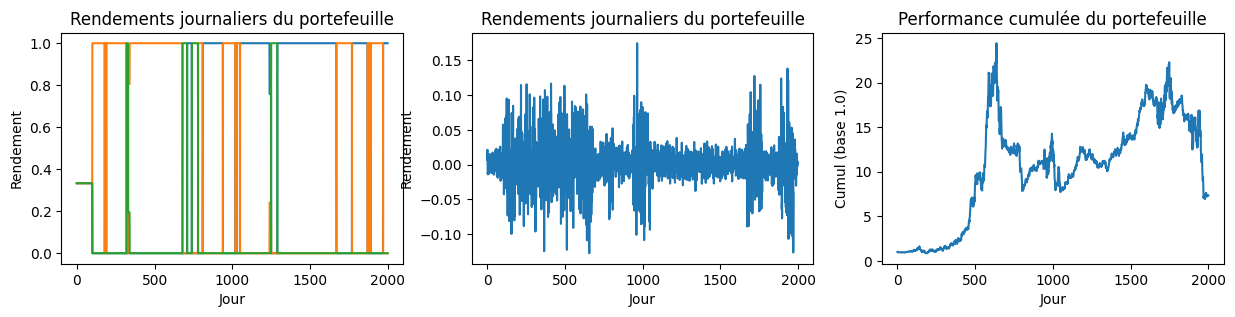

sharpe ratio 0.7554563966621411
2.0 10 1


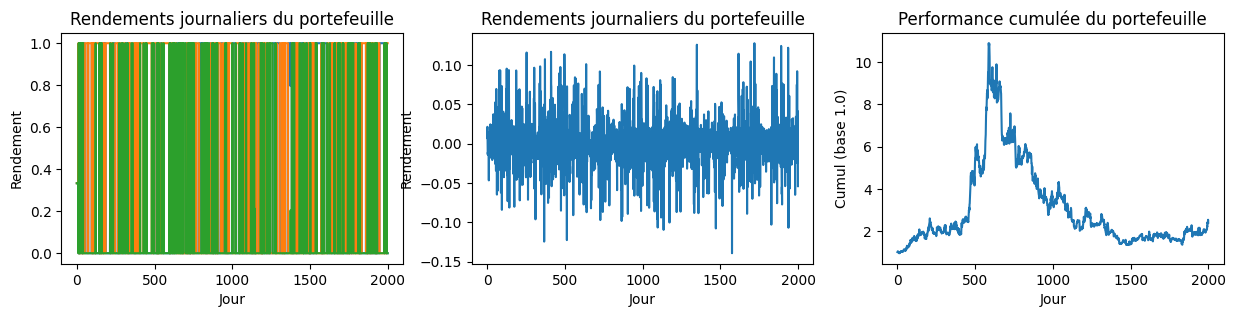

sharpe ratio 0.47099512966462903
2.0 10 10


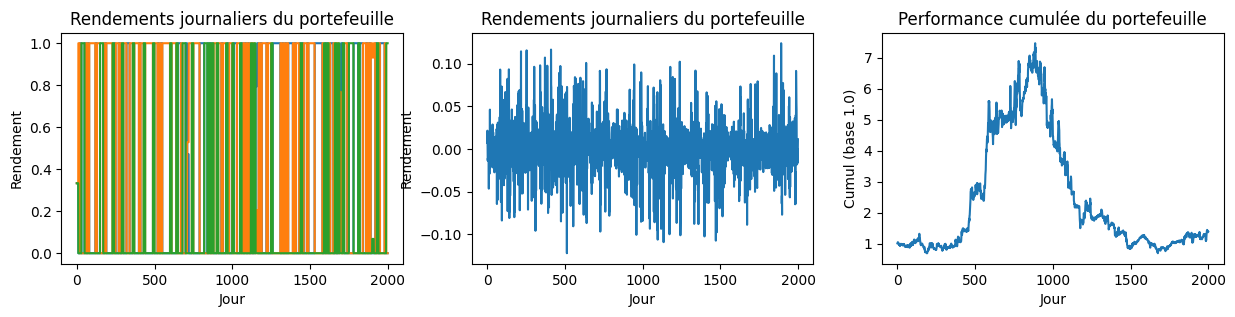

sharpe ratio 0.32974741027123433
2.0 100 1


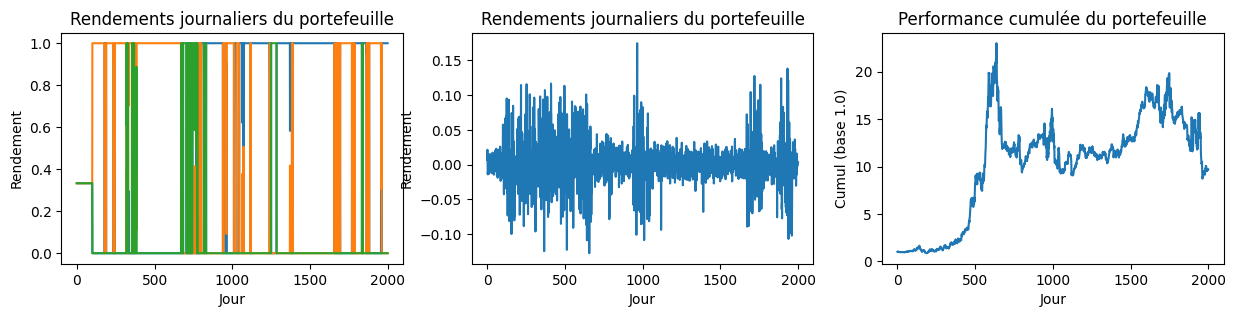

sharpe ratio 0.830720369852017
2.0 100 10


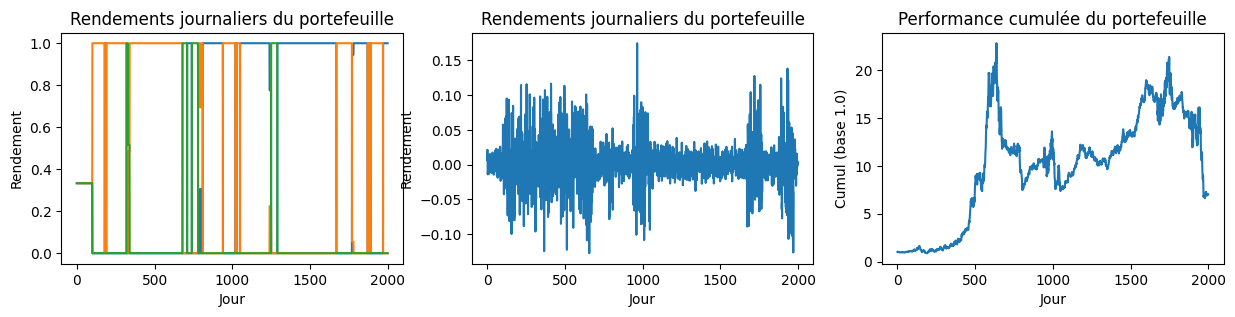

sharpe ratio 0.7445794647505811


In [344]:
risk_aversion_list=[0.5, 1.0, 2.0]
batch_size_list=[10, 100]
overlap_list=[1, 10]

sharpes = list()

for risk_aversion in risk_aversion_list:
    for batch_size in batch_size_list:
        for overlap in overlap_list:
            print(risk_aversion, batch_size, overlap)
            sharpes.append(plot_portfolio_results(returns, risk_aversion=risk_aversion, batch_size=batch_size, overlap=overlap))

In [ ]:
sharpes_arr = np.array(sharpes)

# Nombre de valeurs dans chaque liste
n_ra = len(risk_aversion_list)   # 3
n_bs = len(batch_size_list)      # 3
n_ov = len(overlap_list)         # 3

# On reshape : (3, 3, 3)
sharpes_arr = sharpes_arr.reshape(n_ra, n_bs, n_ov)

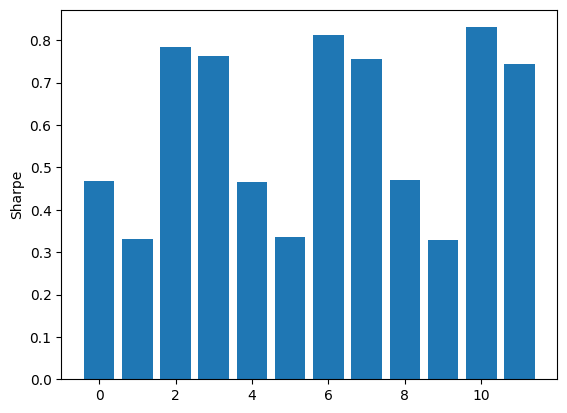

In [358]:

sharpe_values = sharpes_arr.flatten()
plt.figure()
plt.bar(x=np.arange(len(sharpe_values)), height=sharpe_values)
plt.ylabel("Sharpe")
plt.show()